In [50]:
import pandas as pd
import numpy as np
import scipy.io
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
import ngram
import string
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import OrderedDict

In [37]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Read Data

In [38]:
df = pd.read_csv('../Data/Labelled Yelp Dataset.csv')
print(df.columns)
df = df.dropna()
print(df.shape)

Index(['User_id', 'Product_id', 'Rating', 'Date', 'Review', 'Label'], dtype='object')
(359052, 6)


In [39]:
df.duplicated().sum()

0

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


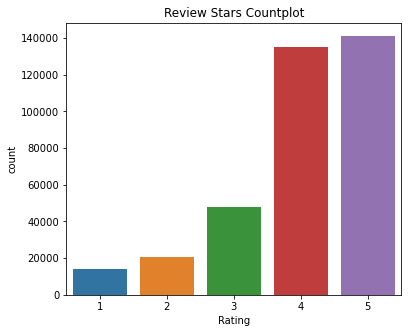

In [40]:
fig, ax = plt.subplots(figsize=(6,5))
sns.countplot(df['Rating'], ax=ax)
plt.title('Review Stars Countplot')
# plt.savefig('stars.png')
plt.show()

#### Feature Extraction

In [52]:
map_five = df['Rating'].groupby(df['User_id']).agg(lambda x: (np.unique(x)==5).all()).to_dict()
map_one = df['Rating'].groupby(df['User_id']).agg(lambda x: (np.unique(x)==1).all()).to_dict()
map_numreviews = df['User_id'].value_counts().to_dict()
df['user_five_star_only'] = df['User_id'].map(map_five).astype(int)
df['user_one_star_only'] = df['User_id'].map(map_one).astype(int)
df['user_num_reviews'] = df['User_id'].map(map_numreviews).astype(int)
df['review_word_count'] = df['Review'].str.split().str.len()

df['user_avg_num_words'] = df.groupby('User_id')['review_word_count'].transform('mean')
df['user_avg_rating'] = df.groupby('User_id')['Rating'].transform('mean')
df['user_std_rating'] = df.groupby('User_id')['Rating'].transform('std')
df

,User_id,Product_id,Rating,Date,Review,Label,reviewer_five_star_only,reviewer_one_star_only,User_num_reviews,review_word_count,...,user_std_rating,user_five_star_only,user_one_star_only,user_num_reviews,user_num_no_words,punctuation_count,title_word_count,upper_case_word_count,user_avg_num_words,user_avg_rating
0,923,0,3,12/8/2014,The food at snack is a selection of popular Gr...,-1,0,0,39,40,...,0.852083,0,0,39,63.717949,6,6,0,63.717949,4.435897
1,924,0,3,5/16/2013,This little place in Soho is wonderful. I had ...,-1,0,0,1,52,...,NaN,0,0,1,52.000000,10,6,1,52.000000,3.000000
2,925,0,4,7/1/2013,ordered lunch for 15 from Snack last Friday. Â...,-1,0,0,2,34,...,0.000000,0,0,2,38.000000,5,6,3,38.000000,4.000000
3,926,0,4,7/28/2011,This is a beautiful quaint little restaurant o...,-1,0,0,1,92,...,NaN,0,0,1,92.000000,14,9,5,92.000000,4.000000
4,927,0,4,11/1/2010,Snack is great place for a Â casual sit down l...,-1,0,0,5,107,...,1.140175,0,0,5,155.000000,18,15,6,155.000000,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359047,161146,349,5,2/6/2014,"I'm very spoiled with Pizza. Really, I have tr...",1,1,0,1,274,...,NaN,1,0,1,274.000000,58,48,9,274.000000,5.000000
359048,116424,349,5,1/31/2014,Can't say enough good things about this place....,1,1,0,2,80,...,0.000000,1,0,2,54.000000,17,10,2,54.000000,5.000000
359049,161147,349,5,1/30/2014,"Had a great dinner here- fantastic pizza, the ...",1,1,0,1,51,...,NaN,1,0,1,51.000000,7,4,1,51.000000,5.000000
359050,97930,349,5,1/25/2014,"Great foods and great drinks, they have even p...",1,1,0,2,24,...,0.000000,1,0,2,43.500000,9,3,0,43.500000,5.000000


In [53]:
df['punctuation_count'] = df['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
df

,User_id,Product_id,Rating,Date,Review,Label,reviewer_five_star_only,reviewer_one_star_only,User_num_reviews,review_word_count,...,user_std_rating,user_five_star_only,user_one_star_only,user_num_reviews,user_num_no_words,punctuation_count,title_word_count,upper_case_word_count,user_avg_num_words,user_avg_rating
0,923,0,3,12/8/2014,The food at snack is a selection of popular Gr...,-1,0,0,39,40,...,0.852083,0,0,39,63.717949,6,6,0,63.717949,4.435897
1,924,0,3,5/16/2013,This little place in Soho is wonderful. I had ...,-1,0,0,1,52,...,NaN,0,0,1,52.000000,10,6,1,52.000000,3.000000
2,925,0,4,7/1/2013,ordered lunch for 15 from Snack last Friday. Â...,-1,0,0,2,34,...,0.000000,0,0,2,38.000000,5,6,3,38.000000,4.000000
3,926,0,4,7/28/2011,This is a beautiful quaint little restaurant o...,-1,0,0,1,92,...,NaN,0,0,1,92.000000,14,9,5,92.000000,4.000000
4,927,0,4,11/1/2010,Snack is great place for a Â casual sit down l...,-1,0,0,5,107,...,1.140175,0,0,5,155.000000,18,15,6,155.000000,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359047,161146,349,5,2/6/2014,"I'm very spoiled with Pizza. Really, I have tr...",1,1,0,1,274,...,NaN,1,0,1,274.000000,58,48,9,274.000000,5.000000
359048,116424,349,5,1/31/2014,Can't say enough good things about this place....,1,1,0,2,80,...,0.000000,1,0,2,54.000000,17,10,2,54.000000,5.000000
359049,161147,349,5,1/30/2014,"Had a great dinner here- fantastic pizza, the ...",1,1,0,1,51,...,NaN,1,0,1,51.000000,7,4,1,51.000000,5.000000
359050,97930,349,5,1/25/2014,"Great foods and great drinks, they have even p...",1,1,0,2,24,...,0.000000,1,0,2,43.500000,9,3,0,43.500000,5.000000


In [54]:
# Pre-processing Text Reviews
# Remove Stop Words
stop = stopwords.words('english')
print(stop)
df['Review'] = df['Review'].apply(
    lambda x: ' '.join(word for word in x.split() if word not in stop))

# Remove Punctuations
tokenizer = RegexpTokenizer(r'\w+')
df['Review'] = df['Review'].apply(
    lambda x: ' '.join(word for word in tokenizer.tokenize(x)))

# Lowercase Words
df['Review'] = df['Review'].apply(
    lambda x: x.lower())
print("Data Cleaning Complete")
df

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,User_id,Product_id,Rating,Date,Review,Label,reviewer_five_star_only,reviewer_one_star_only,User_num_reviews,review_word_count,...,user_std_rating,user_five_star_only,user_one_star_only,user_num_reviews,user_num_no_words,punctuation_count,title_word_count,upper_case_word_count,user_avg_num_words,user_avg_rating
0,923,0,3,12/8/2014,the food snack selection popular greek dishes ...,-1,0,0,39,40,...,0.852083,0,0,39,63.717949,6,6,0,63.717949,4.435897
1,924,0,3,5/16/2013,this little place soho wonderful i lamb sandwi...,-1,0,0,1,52,...,NaN,0,0,1,52.000000,10,6,1,52.000000,3.000000
2,925,0,4,7/1/2013,ordered lunch 15 snack last friday â on time n...,-1,0,0,2,34,...,0.000000,0,0,2,38.000000,5,6,3,38.000000,4.000000
3,926,0,4,7/28/2011,this beautiful quaint little restaurant pretty...,-1,0,0,1,92,...,NaN,0,0,1,92.000000,14,9,5,92.000000,4.000000
4,927,0,4,11/1/2010,snack great place â casual sit lunch especiall...,-1,0,0,5,107,...,1.140175,0,0,5,155.000000,18,15,6,155.000000,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359047,161146,349,5,2/6/2014,i m spoiled pizza really i tried lucali s di f...,1,1,0,1,274,...,NaN,1,0,1,274.000000,58,48,9,274.000000,5.000000
359048,116424,349,5,1/31/2014,can t say enough good things place i stopped l...,1,1,0,2,80,...,0.000000,1,0,2,54.000000,17,10,2,54.000000,5.000000
359049,161147,349,5,1/30/2014,had great dinner here fantastic pizza s more p...,1,1,0,1,51,...,NaN,1,0,1,51.000000,7,4,1,51.000000,5.000000
359050,97930,349,5,1/25/2014,great foods great drinks even pairing wines pi...,1,1,0,2,24,...,0.000000,1,0,2,43.500000,9,3,0,43.500000,5.000000


In [55]:
# Maximum cosine similarity
review_data = df

res = OrderedDict()

# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].User_id in res:
        res[row[1].User_id].append(row[1].Review)
    else:
        res[row[1].User_id] = [row[1].Review]

individual_reviewer = [{'User_id': k, 'Review': v} for k, v in res.items()]

df2 = dict()
df2['reviewerID'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1

for reviewer_data in individual_reviewer:
    count = count + 1
    # Handle Null/single review gracefully -24-Apr-2019
    try:
        tfidf = vector.fit_transform(reviewer_data['Review'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    maxx = cosine.max()

    # To handle reviewier with just 1 review
    if maxx == -np.inf:
        maxx = 0
        
    df2['reviewerID'][count] = reviewer_data['User_id']
    df2['Maximum Content Similarity'][count] = maxx

df3 = pd.DataFrame(df2, columns=['reviewerID', 'Maximum Content Similarity'])
df3

<ipython-input-55-67e989c5aa1e>:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['reviewerID'] = pd.Series([])
<ipython-input-55-67e989c5aa1e>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['Maximum Content Similarity'] = pd.Series([])


,reviewerID,Maximum Content Similarity
0,923,0.267834
1,924,0.000000
2,925,0.023011
3,926,0.000000
4,927,0.138941
...,...,...
160220,161143,0.000000
160221,161144,0.000000
160222,161145,0.000000
160223,161146,0.000000


In [56]:
# Maximum Number of Reviews per day per reviewer
mnr_df1 = df[['User_id', 'Date']].copy()
mnr_df1 = mnr_df1.groupby(by=['Date', 'User_id']).size().reset_index(name='mnr')
mnr_df1

,Date,User_id,mnr
0,1/1/2007,30334,1
1,1/1/2007,30337,1
2,1/1/2007,30887,1
3,1/1/2007,40148,1
4,1/1/2008,4875,2
...,...,...,...
313428,9/9/2014,157799,1
313429,9/9/2014,159298,1
313430,9/9/2014,159988,1
313431,9/9/2014,160097,1


In [60]:
df

,User_id,Product_id,Rating,Date,Review,Label,reviewer_five_star_only,reviewer_one_star_only,User_num_reviews,review_word_count,...,user_std_rating,user_five_star_only,user_one_star_only,user_num_reviews,user_num_no_words,punctuation_count,title_word_count,upper_case_word_count,user_avg_num_words,user_avg_rating
0,923,0,3,12/8/2014,the food snack selection popular greek dishes ...,-1,0,0,39,40,...,0.852083,0,0,39,63.717949,6,6,0,63.717949,4.435897
1,924,0,3,5/16/2013,this little place soho wonderful i lamb sandwi...,-1,0,0,1,52,...,NaN,0,0,1,52.000000,10,6,1,52.000000,3.000000
2,925,0,4,7/1/2013,ordered lunch 15 snack last friday â on time n...,-1,0,0,2,34,...,0.000000,0,0,2,38.000000,5,6,3,38.000000,4.000000
3,926,0,4,7/28/2011,this beautiful quaint little restaurant pretty...,-1,0,0,1,92,...,NaN,0,0,1,92.000000,14,9,5,92.000000,4.000000
4,927,0,4,11/1/2010,snack great place â casual sit lunch especiall...,-1,0,0,5,107,...,1.140175,0,0,5,155.000000,18,15,6,155.000000,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359047,161146,349,5,2/6/2014,i m spoiled pizza really i tried lucali s di f...,1,1,0,1,274,...,NaN,1,0,1,274.000000,58,48,9,274.000000,5.000000
359048,116424,349,5,1/31/2014,can t say enough good things place i stopped l...,1,1,0,2,80,...,0.000000,1,0,2,54.000000,17,10,2,54.000000,5.000000
359049,161147,349,5,1/30/2014,had great dinner here fantastic pizza s more p...,1,1,0,1,51,...,NaN,1,0,1,51.000000,7,4,1,51.000000,5.000000
359050,97930,349,5,1/25/2014,great foods great drinks even pairing wines pi...,1,1,0,2,24,...,0.000000,1,0,2,43.500000,9,3,0,43.500000,5.000000


In [62]:
df3 = df3.rename(columns={"reviewerID": "User_id", "Maximum Content Similarity": "mcs"})
df_final = pd.merge(df, df3, on="User_id", how="inner")
df_final = pd.merge(df_final, mnr_df1, on=['User_id', 'Date'], how="inner")
df_final = df_final.dropna()
df_final.to_csv('out.csv')
df_final

,User_id,Product_id,Rating,Date,Review,Label,reviewer_five_star_only,reviewer_one_star_only,User_num_reviews,review_word_count,...,user_one_star_only,user_num_reviews,user_num_no_words,punctuation_count,title_word_count,upper_case_word_count,user_avg_num_words,user_avg_rating,mcs,mnr
0,923,0,3,12/8/2014,the food snack selection popular greek dishes ...,-1,0,0,39,40,...,0,39,63.717949,6,6,0,63.717949,4.435897,0.267834,2
1,923,880,3,12/8/2014,salads good prices good pesto lasagna good bit...,-1,0,0,39,29,...,0,39,63.717949,5,4,0,63.717949,4.435897,0.267834,2
2,923,19,5,1/14/2014,the restaurant ground floor typical park slope...,-1,0,0,39,96,...,0,39,63.717949,7,10,2,63.717949,4.435897,0.267834,2
3,923,717,5,1/14/2014,their pickled vegetable soul excellent we dump...,-1,0,0,39,84,...,0,39,63.717949,11,8,0,63.717949,4.435897,0.267834,2
4,923,40,4,5/30/2014,really nice mousaka lovely dã cor inside a bit...,-1,0,0,39,43,...,0,39,63.717949,5,5,3,63.717949,4.435897,0.267834,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356990,159088,907,5,10/20/2009,love place â tastes like homemade latin food â...,1,0,0,2,100,...,0,2,146.500000,18,17,10,146.500000,4.000000,0.085548,1
357536,159634,909,4,8/4/2014,i ordered lunch special go happy it the sticky...,1,0,0,2,86,...,0,2,144.500000,14,5,3,144.500000,3.500000,0.063792,1
357537,159634,917,3,7/9/2013,the food good atmosphere bit popular scene y i...,1,0,0,2,203,...,0,2,144.500000,39,11,4,144.500000,3.500000,0.063792,1
358887,160984,920,5,5/5/2014,i m native texan i ve what s purported best ba...,1,0,0,2,177,...,0,2,137.000000,42,24,6,137.000000,3.000000,0.067320,1


#### Optional

In [58]:
def concat_lists_of_strings(df, column):
    """Concatenate a series of lists of strings from a column in a dataframe"""
    return [x for list_ in df[column].values for x in list_]

def freq_dist_of_col(df, col):
    """Return a Frequency Distribution of a column"""
    corpus_tokens = concat_lists_of_strings(df, col)
    corpus_freq_dist = FreqDist(corpus_tokens)
    print(f'The number of unique tokens in the corpus is {len(corpus_freq_dist)}')
    return corpus_freq_dist

def review_freq_dis(df, col, n):
    """
    Create a Frequency Distribution of a column of a dataframe and display
    the n most common tokens.
    """
    corpus_freq_dist = freq_dist_of_col(df, col)
    display(corpus_freq_dist.most_common(n))
    
def remove_words(word_list, words_to_remove):
    """Remove all the words in the words_to_remove list from the words_list"""
    return [w for w in word_list if w not in words_to_remove]

In [59]:
df_final['clean_text_tokens'] = df_final['Review'].apply(word_tokenize)
review_freq_dis(df, 'clean_text_tokens', 200)

KeyboardInterrupt: 

In [ ]:
df_final['clean_text_tokens'] = df_final['clean_text_tokens'].apply(lambda x: remove_words(x, ['i','â','!']))
review_freq_dis(df, 'clean_text_tokens', 200)

In [ ]:
df_final